In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
from pathlib import Path
#Plotting

from waterfall_ax import WaterfallChart
import matplotlib.pyplot as plt


In [2]:
#Define the working directory
dir_path = "../Data"
#File names for import
all_data_file = Path(dir_path, "all_data.csv")
revenue_file = Path(dir_path, "revenue_only.csv")
forecast_file = Path(dir_path, "forecast_country.csv")

In [3]:
# Selector

#Select the commercial sampels
#all_commercial = all_data[all_data["Type"] == "Commercial"]
quarter = "Q4 2023"
persona = "Country"
temp = 3
Month_into_quarter = 1
cut_off_date = "2023-10-31"

#Q4_2023_forecast = forecast_data.loc[(forecast_data["Time"] == quarter) & (forecast_data["Forecaster"] == persona)]

In [4]:
#Read in all the data
all_data = pd.read_csv(all_data_file)
revenue_data = pd.read_csv(revenue_file)
forecast_data = pd.read_csv(forecast_file)
forecast_data["Country"] = forecast_data["Country"].replace({"Rest":'Rest-EU'})
forecast_data = forecast_data.rename(columns={"Volume":"Forecast"})


In [5]:
#Select the time periode and the forecaster for the analysis 
Q4_2023_forecast = forecast_data.loc[(forecast_data["Time"] == quarter) & (forecast_data["Forecaster"] == persona)]

In [6]:
Q4_2023_forecast.sample(2)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast
374,Country,Rest-EU,Q4 2023,Reveal,Q4_23,0,0
192,Country,Turkey,Q4 2023,G360 CDx,Q4_23,1838,20


In [7]:
#all_commercial = all_data[all_data["Type"] == "Commercial"]
#Q4_2023_forecast = forecast_data.loc[(forecast_data["Time"] == quarter) & (forecast_data["Forecaster"] == persona)]

In [8]:
#Dict for correcting the country names
country_dict = {'CANADA': 'Canada',
 'SPAIN': 'Spain',
 'ITALY': 'Italy',
 'URUGUAY': 'Latam',
 'BRAZIL': 'Latam',
 'ARGENTINA': 'Latam',
 'HUNGARY': 'Rest-EU',
 'UNITED KINGDOM': 'UK',
 'MEXICO': 'Latam',
 'BELGIUM': 'Rest-EU',
 'TURKEY': 'Turkey',
 'COLOMBIA': 'Latam',
 'PERU': 'Latam',
 'FRANCE': 'France',
 'GERMANY': 'Rest-EU',
 'PORTUGAL': 'Rest-EU',
 'SWITZERLAND': 'Rest-EU',
 'COSTA RICA': 'Latam',
 'CHILE': 'Latam',
 'SWEDEN': 'Rest-EU',
 'NETHERLANDS': 'Rest-EU',
 'DENMARK': 'Rest-EU',
 'IRELAND': 'Rest-EU',
 'GREECE': 'Rest-EU',
 'AUSTRIA': 'Rest-EU',
 'CZECH REPUBLIC': 'Rest-EU',
 'CROATIA': 'Rest-EU',
 'UKRAINE': 'Rest-EU',
 'SLOVENIA': 'Rest-EU',
 'RUSSIA': 'Rest-EU',
 'BELARUS': 'Rest-EU',
 'FINLAND': 'Rest-EU',
 'PUERTO RICO': 'Latam',
 'LITHUANIA': 'Rest-EU',
 'NORTH MACEDONIA': 'Rest-EU',
 'ROMANIA': 'Rest-EU',
 'LUXEMBOURG': 'Rest-EU',
 'POLAND': 'Rest-EU'}

 

In [9]:
#Define function that transforms to same data format
def forecast_periode(data):
    data = " ".join([data[4:], data[0:4]])
    return data

#all_data = all_data["Quarter_Year"].map(forecast_periode)
all_data["Forecast_Region"] = all_data["Reporting Country"].map(country_dict)
#Cast the time period to be in the correct data format
all_data["Quarter_Year"] = all_data["Quarter_Year"].map(forecast_periode)

In [10]:
#Clean up the data set
all_data["Date Received"] = pd.to_datetime(all_data["Date Received"])
all_data = all_data.set_index("Date Received")
all_data = all_data.drop(columns=["Product"], axis = 1)
all_data = all_data.rename(columns={"Reporting Country  ↑":"Country", "new LIMS Project ID":"Product", "Quarter_Year":"Time", 'Sales':"Actuals"})
all_data = all_data[["Forecast_Region","Time", "Product", "Type" , "Actuals"]]
all_data = all_data.sort_index()


In [11]:
#Select the data until the cut off date
all_data = all_data.loc[:cut_off_date ]

In [12]:
#Check the cut of date
print(f"The most recent date in the dataset is {all_data.index.max()}")

The most recent date in the dataset is 2023-10-31 00:00:00


In [13]:
#Select just the Commercial cases
all_commercial = all_data[all_data["Type"] == "Commercial"]

In [14]:
#Group the sales data by country, quarter and product
commercial_grouped = all_commercial.groupby(["Forecast_Region","Time", "Product"])["Actuals"].sum().reset_index()
commercial_grouped = commercial_grouped.rename(columns={"Forecast_Region":"Country"})
commercial_grouped.sample(2)

,Country,Time,Product,Actuals
68,Latam,Q4 2023,G360 CDx,13
94,Rest-EU,Q4 2023,G360 CDx,3


In [15]:
#Plot the forecast data structure
Q4_2023_forecast.sample(2)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast
312,Country,Italy,Q4 2023,G360 CDx,Q4_23,1700,30
375,Country,Rest-EU,Q4 2023,Shield,Q4_23,0,0


In [16]:
#Add the actual results to the forecast dataframe by merging both df
results = pd.merge(Q4_2023_forecast, commercial_grouped, how = "left", on=["Country", "Time", "Product"])

results.sample(2)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast,Actuals
8,Country,UK,Q4 2023,G360 CDx,Q4_23,1545,132,59.0
2,Country,Canada,Q4 2023,Reveal,Q4_23,1200,10,NaN


In [17]:
#Fill na with 0's
results = results.fillna(0,axis = 1)
results.sample(2)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast,Actuals
9,Country,UK,Q4 2023,G360 Infinity,Q4_23,3000,5,1.0
8,Country,UK,Q4 2023,G360 CDx,Q4_23,1545,132,59.0


In [18]:
#Calculate the forecast for the analysis periode and calculate the difference
results["Actuals"] = results["Actuals"].astype(int)
results["Temp_Forecast"] = (results["Forecast"]/temp).astype(float).round(0)
results["Forecast_gap"] = results["Actuals"] - results["Temp_Forecast"]




In [19]:
columns = ["Forecast", "G360 CDx", "G360 Infinity","Reveal","Shield", "Forecast"]

def plot_country_waterfall(country):
    results_by_country = results[results["Country"]== country].reset_index(drop = True)
    #Set the waterfall column to be the absolute forecast gap for each product
    results_by_country["Waterfall"] = results_by_country["Forecast_gap"]
    result_list = results_by_country["Waterfall"].to_list()
    sum_temp_forecast = results_by_country["Temp_Forecast"].sum()
    result_list.insert(0,sum_temp_forecast)
    #result_list.insert(0,results_by_country._get_value(0,"Temp_Forecast"))
    temp_df = pd.Series(result_list)
    temp_df = temp_df.cumsum()
    result_list_final = temp_df.to_list()
    
    
    plt.style.use('dark_background')

    step_names = ["Forecast", "G360 CDx", "G360 Infinity","Reveal","Shield"]
# Plot
    waterfall = WaterfallChart(result_list_final, step_names=step_names)
    color_kwargs = {
    'c_bar_pos': 'lightgreen',
    'c_bar_neg': 'red',
    'c_bar_start': 'white',
    'c_bar_end': 'white',
    'c_text_pos': 'white',    
    'c_text_neg': 'white',
    'c_text_start': 'yellow',
    'c_text_end': 'yellow'
}
    wf_ax = waterfall.plot_waterfall(title=f'Gap Analysis for the { results_by_country.loc[0, "Country"] } ' , color_kwargs=color_kwargs)
    plt.savefig(f"{country}.pdf")

/Users/mhausch/Data/Prod_Dashboards/venv/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = '{:,}'.format(int(df_plot[self.delta_col][i]))
/Users/mhausch/Data/Prod_Dashboards/venv/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = '{:,}'.format(int(df_plot[self.delta_col][i]))
/Users/mhausch/Data/Prod_Dashboards/venv/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

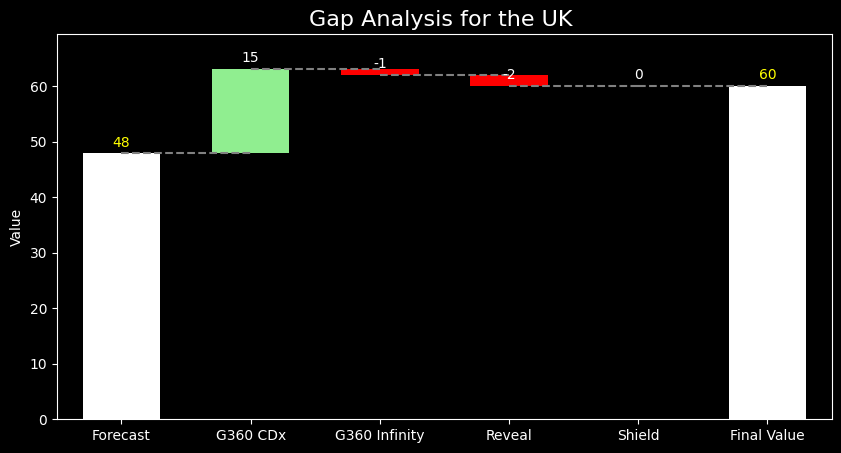

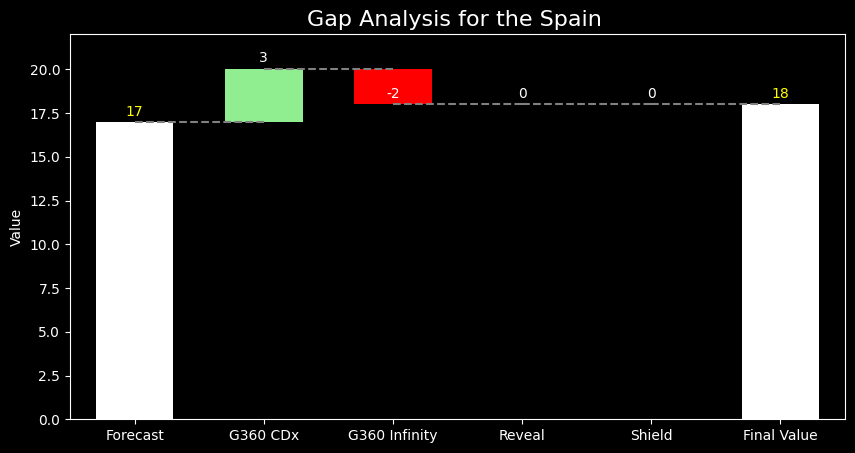

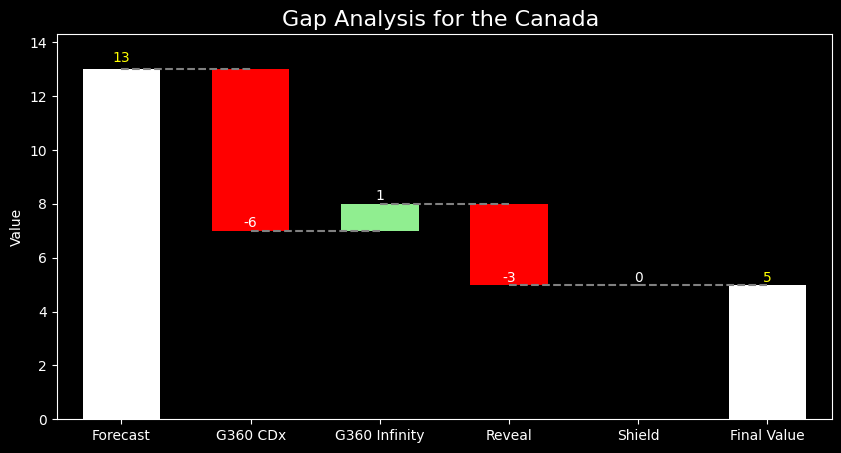

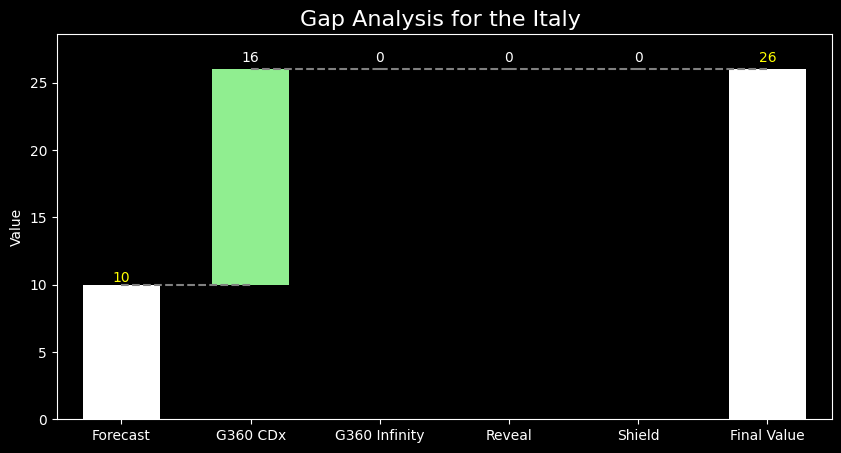

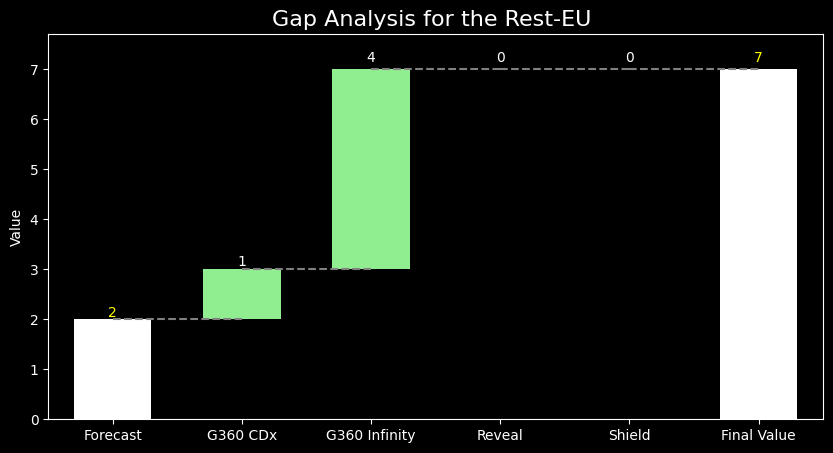

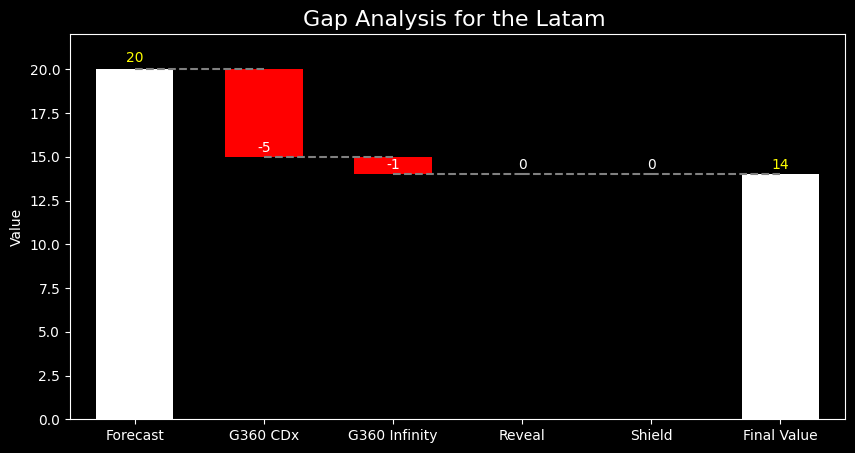

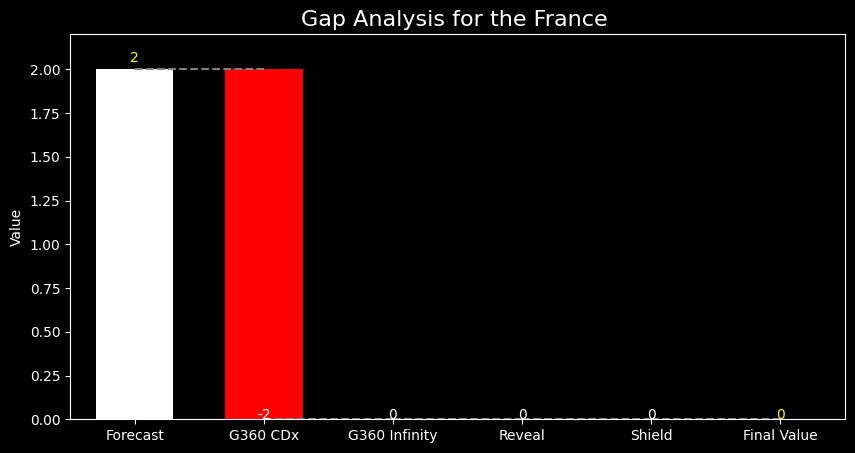

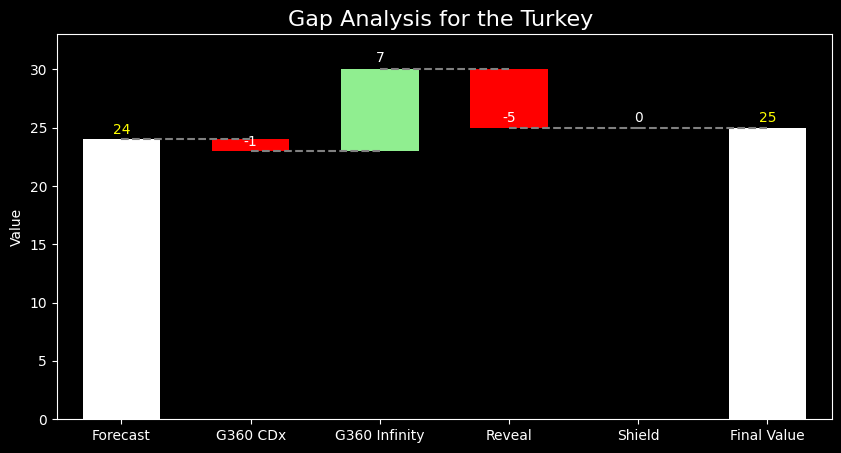

In [20]:
countries = ["UK", "Spain", "Canada", "Italy", "Rest-EU", "Latam", "France", 'Turkey']

for country in countries:
    plot_country_waterfall(country)
    

# Plot the gap analysis for EUAA vs countries

In [21]:
#Define the input dataframe

EUAA_forecast = forecast_data.copy()
EUAA_sales = all_data.copy()

In [22]:
EUAA_sales.sample(2)


,Forecast_Region,Time,Product,Type,Actuals
Date Received,,,,,
2023-07-03,UK,Q3 2023,G360 CDx,Commercial,1
2023-10-06,Rest-EU,Q4 2023,NaN,Biopharma,1


In [23]:
print(f"The maximum date is {EUAA_sales.index.max()}")

The maximum date is 2023-10-31 00:00:00


In [24]:
# Selector

#Select the commercial sampels
EUAA_sales_commercial = EUAA_sales[EUAA_sales["Type"] == "Commercial"]
quarter = "Q4 2023"
persona = "Country"
temp = 3
Month_into_quarter = 1

In [25]:
EUAA_sales_commercial

,Forecast_Region,Time,Product,Type,Actuals
Date Received,,,,,
2020-01-02,UK,Q1 2020,G360 CDx,Commercial,1
2020-01-02,UK,Q1 2020,G360 CDx,Commercial,1
2020-01-02,Turkey,Q1 2020,G360 CDx,Commercial,1
2020-01-02,Turkey,Q1 2020,G360 CDx,Commercial,1
2020-01-02,Spain,Q1 2020,G360 CDx,Commercial,1
...,...,...,...,...,...
2023-10-30,UK,Q4 2023,G360 CDx,Commercial,1
2023-10-30,UK,Q4 2023,G360 CDx,Commercial,1
2023-10-31,UK,Q4 2023,G360 CDx,Commercial,1


In [26]:
#Groupby the country and time periode/quarter
EUAA_sales_commercial = EUAA_sales_commercial.groupby(["Forecast_Region", "Time"])["Actuals"].sum().reset_index()
#Select the time periode for analysis
EUAA_sales_commercial = EUAA_sales_commercial[EUAA_sales_commercial["Time"] == "Q4 2023"]
EUAA_sales_commercial = EUAA_sales_commercial.rename(columns={"Forecast_Region":"Country"})
EUAA_sales_commercial

,Country,Time,Actuals
15,Canada,Q4 2023,5
38,Italy,Q4 2023,26
54,Latam,Q4 2023,14
70,Rest-EU,Q4 2023,7
86,Spain,Q4 2023,18
102,Turkey,Q4 2023,25
118,UK,Q4 2023,60


In [27]:
#Select the time periode for the analysis
EUAA_forecast_filtered = EUAA_forecast.loc[(EUAA_forecast["Time"] == quarter) & (EUAA_forecast["Forecaster"] == persona)]

EUAA_forecast_filtered = EUAA_forecast_filtered.groupby(["Country"])["Forecast"].sum().reset_index()
EUAA_forecast_filtered

,Country,Forecast
0,Canada,42
1,France,5
2,Italy,30
3,Latam,59
4,Rest-EU,5
5,Spain,50
6,Turkey,70
7,UK,142


In [28]:
EUAA_forecast_filtered

,Country,Forecast
0,Canada,42
1,France,5
2,Italy,30
3,Latam,59
4,Rest-EU,5
5,Spain,50
6,Turkey,70
7,UK,142


In [29]:
#Create the results dataframe
EUAA_results = pd.merge(EUAA_forecast_filtered, EUAA_sales_commercial, how = "left", on=["Country"])
EUAA_results = EUAA_results.fillna(0,axis = 1)
EUAA_results["Actuals"] = EUAA_results["Actuals"].astype(int)
EUAA_results["Temp_Forecast"] = (EUAA_results["Forecast"]/temp).astype(float).round(0)
EUAA_results["Forecast_gap"] = EUAA_results["Actuals"] - EUAA_results["Temp_Forecast"]

In [30]:
EUAA_results

,Country,Forecast,Time,Actuals,Temp_Forecast,Forecast_gap
0,Canada,42,Q4 2023,5,14.0,-9.0
1,France,5,0,0,2.0,-2.0
2,Italy,30,Q4 2023,26,10.0,16.0
3,Latam,59,Q4 2023,14,20.0,-6.0
4,Rest-EU,5,Q4 2023,7,2.0,5.0
5,Spain,50,Q4 2023,18,17.0,1.0
6,Turkey,70,Q4 2023,25,23.0,2.0
7,UK,142,Q4 2023,60,47.0,13.0


In [31]:
#Calculate the sum of the forecast gap
sum_temp_forcast =EUAA_results["Temp_Forecast"].sum()
sum_temp_forcast

135.0

In [32]:
country_list = EUAA_results["Country"].to_list()
country_list.insert(0, "Forecast")
country_list

['Forecast',
 'Canada',
 'France',
 'Italy',
 'Latam',
 'Rest-EU',
 'Spain',
 'Turkey',
 'UK']

In [33]:
print(country_list)

['Forecast', 'Canada', 'France', 'Italy', 'Latam', 'Rest-EU', 'Spain', 'Turkey', 'UK']


In [34]:
EUAA_results_list = EUAA_results["Forecast_gap"].to_list()

In [35]:
EUAA_results_list

[-9.0, -2.0, 16.0, -6.0, 5.0, 1.0, 2.0, 13.0]

In [36]:
EUAA_results_list.insert(0,sum_temp_forcast)
#result_list.insert(0,results_by_country._get_value(0,"Temp_Forecast"))
EUAA_temp_df = pd.Series(EUAA_results_list)
EUAA_temp_df = EUAA_temp_df.cumsum()
result_list_final = EUAA_temp_df.to_list()

In [37]:
result_list_final, len(result_list_final)

([135.0, 126.0, 124.0, 140.0, 134.0, 139.0, 140.0, 142.0, 155.0], 9)

/Users/mhausch/Data/Prod_Dashboards/venv/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = '{:,}'.format(int(df_plot[self.delta_col][i]))


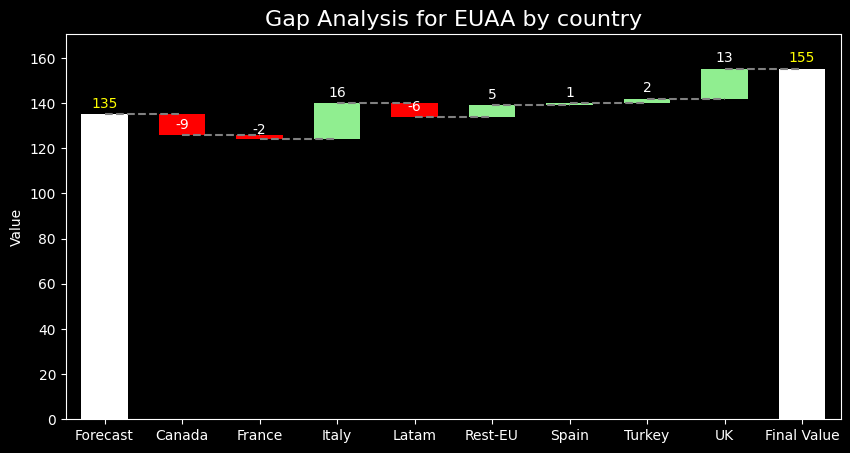

In [38]:
waterfall_EUAA = WaterfallChart(result_list_final, step_names=country_list)
color_kwargs = {
'c_bar_pos': 'lightgreen',
'c_bar_neg': 'red',
'c_bar_start': 'white',
'c_bar_end': 'white',
'c_text_pos': 'white',    
    'c_text_neg': 'white',
    'c_text_start': 'yellow',
    'c_text_end': 'yellow'}
wf_ax = waterfall_EUAA.plot_waterfall(title=f'Gap Analysis for EUAA by country' , color_kwargs=color_kwargs)
plt.savefig(f"EUAA_gap_analysis.pdf")

### EUAA gap analysis by Product

In [39]:
EUAA_forecast = forecast_data.copy()
EUAA_sales = all_data.copy()

In [40]:
EUAA_forecast.head(3)

,Forecaster,Country,Time,Product,5QRF_Starting_Quarter,ASP,Forecast
0,Country,Canada,Q1 2024,G360 CDx,Q4_23,1450,30
1,Country,Canada,Q1 2024,G360 Infinity,Q4_23,1700,9
2,Country,Canada,Q1 2024,Reveal,Q4_23,1700,10


In [41]:
EUAA_sales.head(3)

,Forecast_Region,Time,Product,Type,Actuals
Date Received,,,,,
2020-01-02,UK,Q1 2020,G360 CDx,Commercial,1
2020-01-02,UK,Q1 2020,G360 CDx,Commercial,1
2020-01-02,Turkey,Q1 2020,G360 CDx,Commercial,1


In [42]:
#Select the commercial sampels
EUAA_sales_commercial = EUAA_sales[EUAA_sales["Type"] == "Commercial"]
quarter = "Q4 2023"
persona = "Country"
temp = 3
Month_into_quarter = 1

In [43]:
#Create the sales dataframe for the gap analysis
EUAA_gap_product_input = EUAA_sales[EUAA_sales["Time"] == "Q4 2023"]
EUAA_gap_product_input = EUAA_gap_product_input.groupby(["Product"])["Actuals"].sum().reset_index()
EUAA_gap_product_input = EUAA_gap_product_input.rename(columns={"Forecast_Region":"Country"})
EUAA_gap_product_input

,Product,Actuals
0,G360 CDx,127
1,G360 Infinity,28
2,Reveal,2


In [44]:
#Create the forecast dataframe for the gap analysis
EUAA_gap_product_forecast = EUAA_forecast.loc[(EUAA_forecast["Time"] == quarter) & (EUAA_forecast["Forecaster"] == persona)]
EUAA_gap_product_forecast = EUAA_gap_product_forecast.groupby(["Product"])["Forecast"].sum().reset_index()
EUAA_gap_product_forecast

,Product,Forecast
0,G360 CDx,316
1,G360 Infinity,57
2,Reveal,30
3,Shield,0


In [45]:
EUAA_gap_product_forecast = pd.merge(EUAA_gap_product_input, EUAA_gap_product_forecast, how = "left", on=["Product"])
EUAA_gap_product_forecast

,Product,Actuals,Forecast
0,G360 CDx,127,316
1,G360 Infinity,28,57
2,Reveal,2,30


In [46]:
EUAA_gap_product_forecast = EUAA_gap_product_forecast.fillna(0,axis = 1)
EUAA_gap_product_forecast["Actuals"] = EUAA_gap_product_forecast["Actuals"].astype(int)
EUAA_gap_product_forecast["Temp_Forecast"] = (EUAA_gap_product_forecast["Forecast"]/temp).astype(float).round(0)
EUAA_gap_product_forecast["Forecast_gap"] = EUAA_gap_product_forecast["Actuals"] - EUAA_gap_product_forecast["Temp_Forecast"]

In [47]:
EUAA_gap_product_forecast

,Product,Actuals,Forecast,Temp_Forecast,Forecast_gap
0,G360 CDx,127,316,105.0,22.0
1,G360 Infinity,28,57,19.0,9.0
2,Reveal,2,30,10.0,-8.0


In [48]:
#Calculate the sum of the forecast gap
sum_temp_forcast_prod =EUAA_gap_product_forecast["Temp_Forecast"].sum()
sum_temp_forcast_prod 


134.0

In [49]:
prod_list = EUAA_gap_product_forecast["Product"].to_list()
prod_list.insert(0, "Forecast")
prod_list

['Forecast', 'G360 CDx', 'G360 Infinity', 'Reveal']

In [51]:
EUAA_results_list_prod = EUAA_gap_product_forecast["Forecast_gap"].to_list()
EUAA_results_list_prod.insert(0,sum_temp_forcast_prod)

In [52]:
EUAA_results_list_prod

[134.0, 22.0, 9.0, -8.0]

In [53]:
EUAA_temp_df_prod = pd.Series(EUAA_results_list_prod)
EUAA_temp_df_prod = EUAA_temp_df_prod.cumsum()
result_list_final_prod = EUAA_temp_df_prod.to_list()

In [54]:
result_list_final_prod

[134.0, 156.0, 165.0, 157.0]

In [ ]:
step_names_EUAA_by_product = EUAA_gap_product_forecast["Product"].to_list()
step_names_EUAA_by_product

/Users/mhausch/Data/Prod_Dashboards/venv/lib/python3.9/site-packages/waterfall_ax/waterfall_ax.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = '{:,}'.format(int(df_plot[self.delta_col][i]))


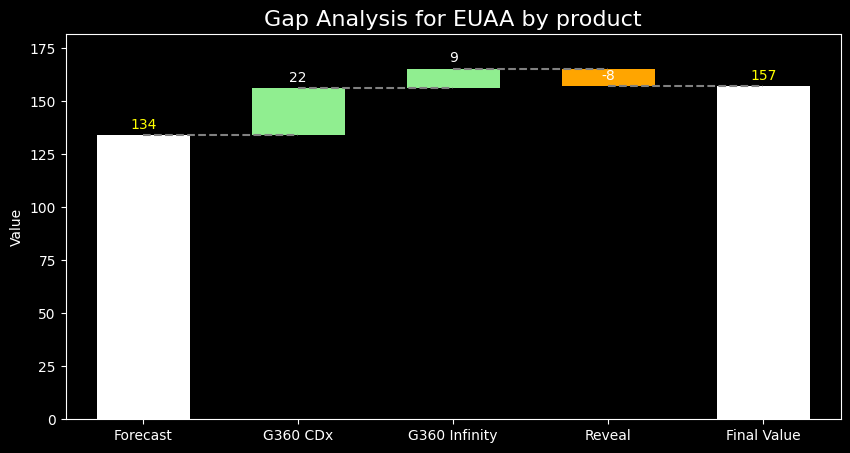

In [55]:
waterfall_EUAA = WaterfallChart(result_list_final_prod,step_names= prod_list )
color_kwargs = {
'c_bar_pos': 'lightgreen',
'c_bar_neg': 'orange',
'c_bar_start': 'white',
'c_bar_end': 'white',
'c_text_pos': 'white',    
    'c_text_neg': 'white',
    'c_text_start': 'yellow',
    'c_text_end': 'yellow'}
wf_ax = waterfall_EUAA.plot_waterfall(title=f'Gap Analysis for EUAA by product' , color_kwargs=color_kwargs)
plt.savefig(f"EUAA_gap_analysis_by_product.pdf")